In [187]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings(action='once')
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
%matplotlib inline

In [188]:
# def over_sampling(df):
#     df_poi_1 = df[df['poi'] == True]
#     count_poi_1 = df_poi_1.shape[0]
#     df_poi_1_over = df_poi_1.sample(count_poi_0, replace=True)
    
#     return pd.concat([df_poi_0, df_poi_1_over], axis=0)

def over_sampling(X, Y):
    smote = SMOTE(sampling_strategy='minority')
    return smote.fit_sample(X, Y)

In [189]:
# 讀取訓練資料
data_dir = './data'
df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))

X_train = df.drop(['poi'], axis=1)
Y_train = df['poi']
train_num = Y_train.shape[0]

In [190]:
print(X_train.shape)
X_train

(113, 21)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
5,HIRKO JOSEPH,NaN,10259.0,NaN,NaN,joe.hirko@enron.com,30766064.0,77978.0,NaN,NaN,NaN,NaN,NaN,2856.0,NaN,NaN,NaN,NaN,NaN,91093.0,30766064.0
6,YEAGER F SCOTT,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552.0,53947.0,NaN,NaN,NaN,NaN,NaN,147950.0,3576206.0,NaN,158403.0,NaN,NaN,360300.0,11884758.0
7,COLWELL WESLEY,1200000.0,27610.0,-144062.0,NaN,wes.colwell@enron.com,NaN,16514.0,40.0,240.0,11.0,NaN,NaN,101740.0,698242.0,NaN,288542.0,1132.0,1758.0,1490344.0,698242.0
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,16.0,81525000.0,3600000.0,10359729.0,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
9,GLISAN JR BEN F,600000.0,NaN,NaN,NaN,ben.glisan@enron.com,384728.0,125978.0,16.0,52.0,6.0,NaN,71023.0,200308.0,393818.0,NaN,274975.0,874.0,873.0,1272284.0,778546.0


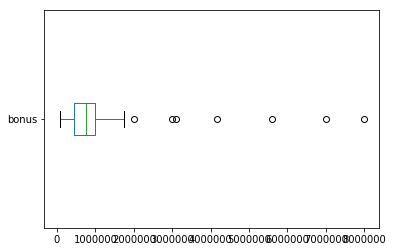

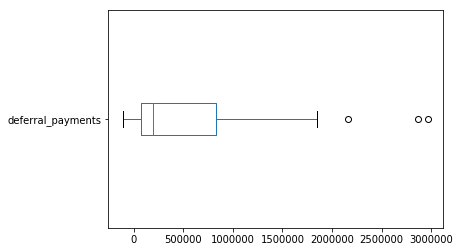

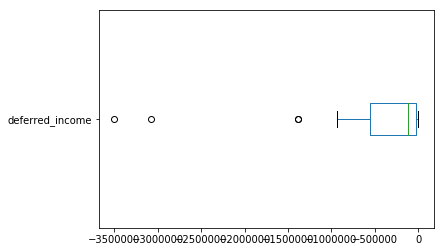

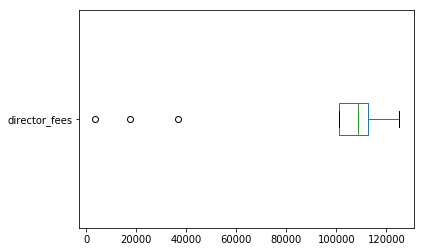

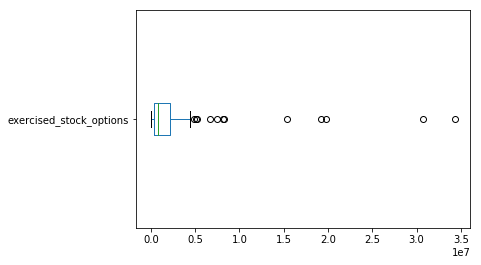

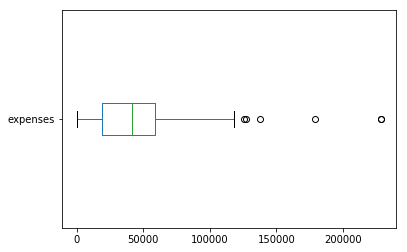

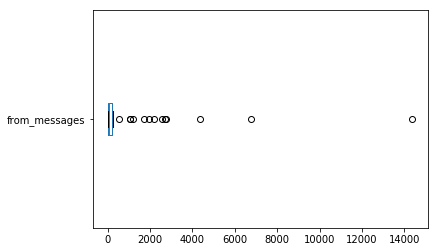

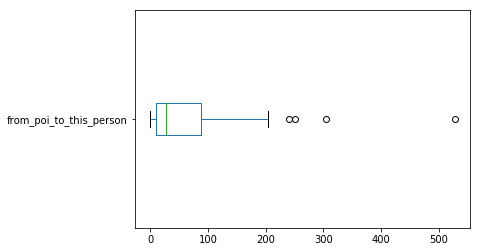

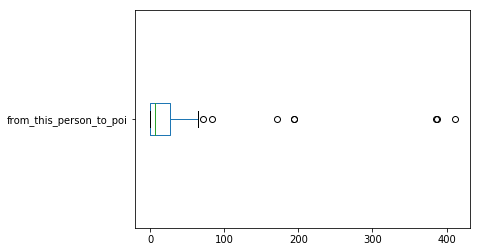

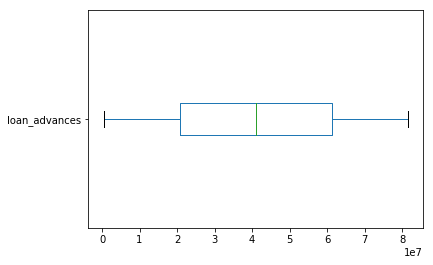

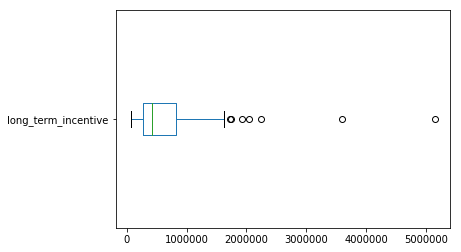

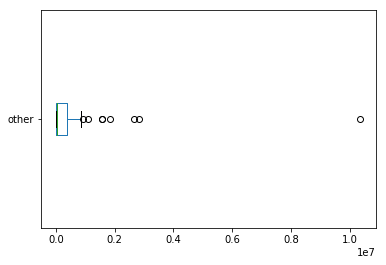

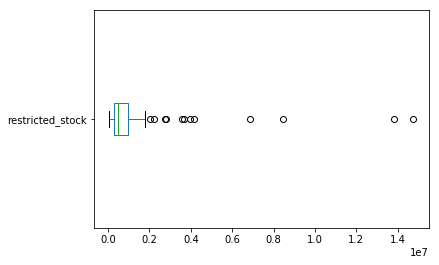

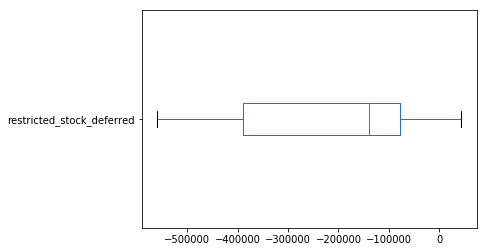

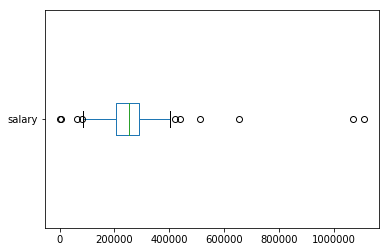

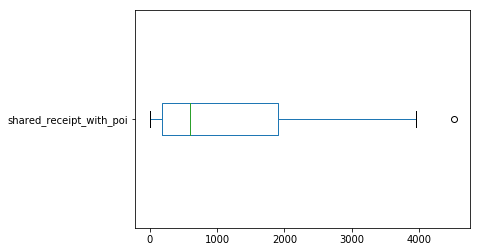

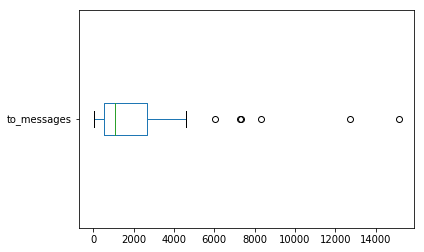

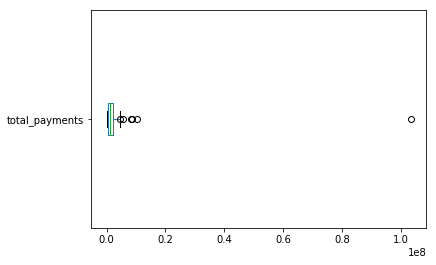

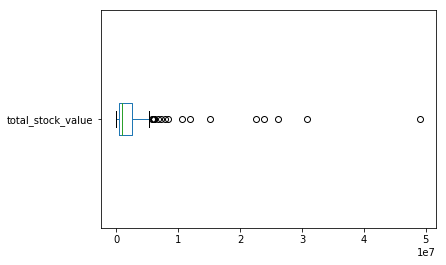

In [191]:
# 篩選數字欄位
numeric = X_train.select_dtypes(include='number')

# 將值有 0、1 兩種值的欄位篩選掉
numeric_columns = list(numeric.columns[numeric.apply(lambda x: len(x.unique()) != 2)])

for col in numeric_columns:
    X_train[col].plot.box(vert=False)
    plt.show()

In [198]:
def is_not_null(x):
    if not pd.isnull(x):
        return 1.0
    else:
        return 0.0

    
# 第一次轉換：自己決定的轉換方式
# 建議使用前先用 `df.copy()` 拷貝一份資料
def transform_1(df):
    
    # 把最大值換成第二大
    # 也可以是最小值或其他目標值
    def replace_outlier(col, method='max'):
        # 用來取得目標值
        # 如果 method 為 `max`，`fn` 就是 `df[col].max`
        fn = getattr(df[col], method)
        
        # 用來篩選目標值
        mask = df[col] != fn()
        
        # 取得篩選過後的目標值
        fn_2 = getattr(df.loc[mask, col], method)
        
        # 將目標值替換掉
        df.loc[~mask, col] = fn_2()

    
    # 轉換為「是否存在」
    to_is_not_null = [
        'email_address',
        'restricted_stock_deferred'
    ]
    for col in to_is_not_null:
        df['has_' + col] = df[col].apply(is_not_null)

    
    # 要替換成 0 的欄位
    na_to_zero = [
        'bonus',
        'deferral_payments',
        'deferred_income',
        'director_fees',
        'loan_advances'
    ]
    
    for col in na_to_zero:
        df[col] = df[col].fillna(0)
        
    # 要替換成中位數的欄位
    na_to_median = [
        'salary'
    ]
    
    for col in na_to_median:
        df[col] = df[col].fillna(df[col].median())

    # 替換掉離群值
    replace_outlier('other', 'max')
    replace_outlier('total_payments', 'max')
    replace_outlier('total_stock_value', 'max')
    
    # 要 drop 掉的欄位
    to_drop = [
        'name',
        'email_address',
    ]
    df = df.drop(to_drop, axis=1)
    
    return df

In [199]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [200]:
# 第二次轉換：各種可能都跑看看
# 建議使用前先拷貝一份資料
def transform_2(df, fill, scaler):
    for col in df.columns:
        df[col] = df[col].fillna(fill)
        
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(list(df[col].values))
        elif scaler != None and not col.startswith('has_'):
            df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

    return df

# 資料轉換
# 建議使用前先拷貝一份資料
def transform(df, fill=0, scaler=None):
    df = transform_1(df)
    return transform_2(df, fill, scaler)

# 交叉測試
def compute_score(model, data, target):
    return cross_val_score(model, data, target, cv=5).mean()

# 用來顯示測試結果
class Result:
    def __init__(self):
        self.result_columns = ['Estimator', 'Args', 'Filling', 'Scaler', 'Score']
        self.result = pd.DataFrame(columns=self.result_columns)

    def append(self, model, args, fill_name, scaler, score):
        row = pd.DataFrame([[
            type(model).__name__,                                       # 模型
            args,                                                                # 參數
            fill_name,                                                          # 填補值
            type(scaler).__name__ if scaler != None else '-',    # scaler
            score                                                               # 分數
        ]], columns=self.result_columns)
        
        self.result = self.result.append(row, ignore_index=True, sort=True)
    
    def show(self):
        # 按照分數排序
        return self.result.sort_values(by=['Score'], ascending=False)

In [201]:
# 各種填補值
fills = {
    '-1': -1,
    'zero': 0,
#     'mean': df.mean(),
#     'mid': df.median(),
    'max': df.max(),
    'min': df.min()
}

# 各種 scaler
scalers = [None, MinMaxScaler(), StandardScaler()]

# 各種模型和參數
estimators = [
    {
        'model': LogisticRegression,
        'args_list': [
            {
                'solver': 'liblinear',
                'max_iter': 1000
            }
        ],
    },
    {
        'model': GradientBoostingClassifier,
        'args_list': [
            {
                'n_estimators': 100,
                'learning_rate': 0.1
            },
            {
                'n_estimators': 50,
                'learning_rate': 0.1
            },
            {
                'n_estimators': 150,
                'learning_rate': 0.1
            },
        ]
    },
    {
        'model': RandomForestClassifier,
        'args_list': [
            {
                'n_estimators': 20
            },
            {
                'n_estimators': 100
            }
        ]
    }
]

# 把各種填補值、scaler、模型及參數都丟進去跑跑看，用 `cross_val_score` 做評分
def find_best_args(data, target):
    result = Result()
    
    for estimator in estimators:
        for args in estimator['args_list']:
            for fill_name, fill in fills.items():
                for scaler in scalers:
                    model = estimator['model'](**args)
                    data_tmp = data.copy() # 拷貝一份資料避免測試結果互相干擾
                    data_tmp = transform(data_tmp, fill, scaler)
                    X_tmp, Y_tmp = over_sampling(data_tmp, target)
                    score = compute_score(model,X_tmp, Y_tmp)
                    result.append(model, args, fill_name, scaler, score)
                    
    return result

find_best_args(X_train, Y_train).show()

,Args,Estimator,Filling,Scaler,Score
69,{'n_estimators': 100},RandomForestClassifier,min,-,0.985
54,{'n_estimators': 20},RandomForestClassifier,max,-,0.980
58,{'n_estimators': 20},RandomForestClassifier,min,MinMaxScaler,0.980
67,{'n_estimators': 100},RandomForestClassifier,max,MinMaxScaler,0.975
57,{'n_estimators': 20},RandomForestClassifier,min,-,0.975
68,{'n_estimators': 100},RandomForestClassifier,max,StandardScaler,0.970
56,{'n_estimators': 20},RandomForestClassifier,max,StandardScaler,0.970
71,{'n_estimators': 100},RandomForestClassifier,min,StandardScaler,0.965
59,{'n_estimators': 20},RandomForestClassifier,min,StandardScaler,0.965
66,{'n_estimators': 100},RandomForestClassifier,max,-,0.965


In [202]:
# 訓練模型
def train(data, target):
    # 拷貝並轉換資料
    data_tmp = data.copy()
    data_tmp = transform(data_tmp, fill=0, scaler=StandardScaler())
    X_tmp, Y_tmp = over_sampling(data_tmp, target)

    # 建立模型
#     model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1)
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_tmp, Y_tmp)

    return model

model = train(X_train, Y_train)

In [203]:
# 讀取測試資料
df_test = pd.read_csv(os.path.join(data_dir, 'test_features.csv'))

def test(model, data):
    # 拷貝並轉換資料
    data_tmp = data.copy()
    X_test =  transform(data_tmp, fill=0, scaler=StandardScaler())

    # 使用模型進行預測
    Y_pred = model.predict_proba(X_test)
    
    # 只取第二個欄位
    return Y_pred[:, 1]

Y_pred = test(model, df_test)

In [204]:
# 轉換為提交所需格式
def to_submit(df, Y_pred):
    submit = df[['name']]
    submit['poi'] = Y_pred
    return submit

submit = to_submit(df_test, Y_pred)
submit

/Users/ucfan/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,name,poi
0,BELDEN TIMOTHY N,0.30
1,BOWEN JR RAYMOND M,0.70
2,HANNON KEVIN P,0.66
3,DELAINEY DAVID W,0.41
4,CAUSEY RICHARD A,0.77
5,HICKERSON GARY J,0.62
6,FREVERT MARK A,0.62
7,CHAN RONNIE,0.18
8,DONAHUE JR JEFFREY M,0.63
9,REYNOLDS LAWRENCE,0.27


In [205]:
output_dir = '.'

# 輸出 csv 到指定位置
submit.to_csv(os.path.join(output_dir, 'submission.csv'), encoding='utf-8', index=False)